# Feature Engineering for Next Purchase Prediction

This notebook creates comprehensive features for modeling customer purchase behavior:

## Feature Categories:
1. **User-Level Features** - Customer behavior patterns, preferences, temporal patterns
2. **Item-Level Features** - Product popularity, reorder rates, category statistics  
3. **User-Item Interaction Features** - Purchase history, recency, frequency patterns
4. **Temporal Features** - Time-based patterns, seasonality, ordering sequences
5. **Context Features** - Cart position, order composition, cross-category behavior

## Outputs:
- `data/features/user_features.parquet` - User behavioral features
- `data/features/item_features.parquet` - Product-level features  
- `data/features/user_item_features.parquet` - Interaction features
- Feature documentation and schemas

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats
import gc

# Configure settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
warnings.filterwarnings('ignore')
plt.style.use('default')

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Data Loading

Load processed data from the EDA notebook and raw datasets.

In [2]:
# Define paths
DATA_RAW_PATH = "../data/raw/"
DATA_PROCESSED_PATH = "../data/processed/"
DATA_FEATURES_PATH = "../data/features/"

# Create features directory if not exists
import os
os.makedirs(DATA_FEATURES_PATH, exist_ok=True)

print("Loading datasets...")

# Load raw data
orders = pd.read_csv(DATA_RAW_PATH + "orders.csv")
order_products_prior = pd.read_csv(DATA_RAW_PATH + "order_products__prior.csv")
order_products_train = pd.read_csv(DATA_RAW_PATH + "order_products__train.csv")

# Combine order products
order_products = pd.concat([order_products_prior, order_products_train], ignore_index=True)

# Load processed data from EDA notebook
try:
    products_enriched = pd.read_parquet(DATA_PROCESSED_PATH + "products_enriched.parquet")
    users_rfm = pd.read_parquet(DATA_PROCESSED_PATH + "users_rfm.parquet")
    print("✓ Processed data loaded from EDA notebook")
except FileNotFoundError:
    # Fallback: load and recreate if not found
    products = pd.read_csv(DATA_RAW_PATH + "products.csv")
    aisles = pd.read_csv(DATA_RAW_PATH + "aisles.csv")
    departments = pd.read_csv(DATA_RAW_PATH + "departments.csv")
    products_enriched = products.merge(aisles, on='aisle_id').merge(departments, on='department_id')
    users_rfm = None
    print("! Loading from raw data (run EDA notebook first for optimal features)")

print(f"Orders: {orders.shape}")
print(f"Order products: {order_products.shape}")
print(f"Products enriched: {products_enriched.shape}")
if users_rfm is not None:
    print(f"Users RFM: {users_rfm.shape}")

print("Data loaded successfully!")

Loading datasets...
✓ Processed data loaded from EDA notebook
Orders: (3421083, 7)
Order products: (33819106, 4)
Products enriched: (49688, 6)
Users RFM: (206209, 9)
Data loaded successfully!


## 2. User-Level Features

Create comprehensive features describing user behavior patterns.

In [3]:
print("Creating user-level features...")

# Start with basic user metrics from orders
user_features = orders.groupby('user_id').agg({
    'order_number': ['max', 'count'],  # max = total orders, count should be same
    'order_dow': ['mean', 'std', 'nunique'],  # day of week preferences
    'order_hour_of_day': ['mean', 'std', 'nunique'],  # hour preferences  
    'days_since_prior_order': ['mean', 'std', 'min', 'max']  # ordering frequency patterns
}).round(2)

# Flatten column names
user_features.columns = [
    'user_total_orders', 'user_order_count',
    'user_avg_dow', 'user_std_dow', 'user_unique_dow',
    'user_avg_hour', 'user_std_hour', 'user_unique_hours',
    'user_avg_days_between_orders', 'user_std_days_between_orders', 
    'user_min_days_between_orders', 'user_max_days_between_orders'
]

# Remove duplicate column (total_orders = order_count)
user_features = user_features.drop('user_order_count', axis=1)

# Handle missing values for single-order users  
user_features = user_features.fillna(0)

print(f"Basic user features shape: {user_features.shape}")
print("Sample user features:")
display(user_features.head())

Creating user-level features...
Basic user features shape: (206209, 11)
Sample user features:


,user_total_orders,user_avg_dow,user_std_dow,user_unique_dow,user_avg_hour,user_std_hour,user_unique_hours,user_avg_days_between_orders,user_std_days_between_orders,user_min_days_between_orders,user_max_days_between_orders
user_id,,,,,,,,,,,
1,11,2.64,1.29,4,10.09,3.48,7,19.00,9.03,0.0,30.0
2,15,2.07,1.22,5,10.60,1.50,5,16.29,10.27,3.0,30.0
3,13,1.38,1.66,5,16.31,1.44,6,12.00,5.13,7.0,21.0
4,6,4.50,1.05,4,12.50,1.52,4,17.00,10.98,0.0,30.0
5,5,1.40,1.52,3,15.00,3.32,4,11.50,5.45,6.0,19.0


In [4]:
# Add order size features (products per order)
print("Adding order size and product diversity features...")

# Get order sizes per user
user_order_sizes = orders[['order_id', 'user_id']].merge(
    order_products.groupby('order_id').size().reset_index().rename(columns={0: 'order_size'}),
    on='order_id'
)

order_size_features = user_order_sizes.groupby('user_id')['order_size'].agg([
    'mean', 'std', 'min', 'max', 'median'
]).round(2)

order_size_features.columns = [
    'user_avg_basket_size', 'user_std_basket_size', 'user_min_basket_size', 
    'user_max_basket_size', 'user_median_basket_size'
]

# Add total products purchased by user
user_total_products = order_products.merge(orders[['order_id', 'user_id']], on='order_id') \
                                   .groupby('user_id')['product_id'].count().reset_index()
user_total_products.columns = ['user_id', 'user_total_products']
user_total_products = user_total_products.set_index('user_id')

# Add unique products purchased by user
user_unique_products = order_products.merge(orders[['order_id', 'user_id']], on='order_id') \
                                     .groupby('user_id')['product_id'].nunique().reset_index()
user_unique_products.columns = ['user_id', 'user_unique_products'] 
user_unique_products = user_unique_products.set_index('user_id')

# Combine all user features
user_features = user_features.join([order_size_features, user_total_products, user_unique_products], how='left')

# Calculate additional metrics
user_features['user_avg_products_per_order'] = (user_features['user_total_products'] / user_features['user_total_orders']).round(2)
user_features['user_product_discovery_rate'] = (user_features['user_unique_products'] / user_features['user_total_products']).round(3)

# Handle any remaining NaN values
user_features = user_features.fillna(0)

print(f"Enhanced user features shape: {user_features.shape}")
print("\nUser features columns:")
print(list(user_features.columns))

Adding order size and product diversity features...
Enhanced user features shape: (206209, 20)

User features columns:
['user_total_orders', 'user_avg_dow', 'user_std_dow', 'user_unique_dow', 'user_avg_hour', 'user_std_hour', 'user_unique_hours', 'user_avg_days_between_orders', 'user_std_days_between_orders', 'user_min_days_between_orders', 'user_max_days_between_orders', 'user_avg_basket_size', 'user_std_basket_size', 'user_min_basket_size', 'user_max_basket_size', 'user_median_basket_size', 'user_total_products', 'user_unique_products', 'user_avg_products_per_order', 'user_product_discovery_rate']


In [6]:
# Add reorder behavior features
print("Adding reorder behavior features...")

# Calculate user reorder statistics
user_reorders = order_products.merge(orders[['order_id', 'user_id']], on='order_id')

reorder_features = user_reorders.groupby('user_id').agg({
    'reordered': ['mean', 'sum', 'count']
}).round(3)

reorder_features.columns = ['user_reorder_rate', 'user_total_reorders', 'user_total_order_items']

# Add department/aisle diversity features  
print("Adding product category diversity features...")

# Get user's department diversity
user_dept_diversity = order_products.merge(orders[['order_id', 'user_id']], on='order_id') \
                                   .merge(products_enriched[['product_id', 'department_id', 'department', 'aisle_id', 'aisle']], on='product_id')

user_dept_features = user_dept_diversity.groupby('user_id').agg({
    'department_id': ['nunique']
}).round(0)

user_dept_features.columns = ['user_unique_departments']

# Get user's aisle diversity  
user_aisle_features = user_dept_diversity.groupby('user_id').agg({
    'aisle_id': ['nunique']
}).round(0)

user_aisle_features.columns = ['user_unique_aisles']

# Combine reorder and diversity features
user_features = user_features.join([reorder_features, user_dept_features, user_aisle_features], how='left')

# Calculate additional derived features
user_features['user_reorder_ratio'] = (user_features['user_total_reorders'] / user_features['user_total_order_items']).round(3)
user_features['user_dept_exploration'] = (user_features['user_unique_departments'] / 21).round(3)  # 21 total departments
user_features['user_aisle_exploration'] = (user_features['user_unique_aisles'] / 134).round(3)    # 134 total aisles

# Clean any remaining NaN values
user_features = user_features.fillna(0)

print(f"Final user features shape: {user_features.shape}")
print(f"New columns added: {user_features.shape[1] - 20}")

# Show sample of final user features
display(user_features.head())

Adding reorder behavior features...
Adding product category diversity features...
Final user features shape: (206209, 28)
New columns added: 8


,user_total_orders,user_avg_dow,user_std_dow,user_unique_dow,user_avg_hour,user_std_hour,user_unique_hours,user_avg_days_between_orders,user_std_days_between_orders,user_min_days_between_orders,user_max_days_between_orders,user_avg_basket_size,user_std_basket_size,user_min_basket_size,user_max_basket_size,user_median_basket_size,user_total_products,user_unique_products,user_avg_products_per_order,user_product_discovery_rate,user_reorder_rate,user_total_reorders,user_total_order_items,user_unique_departments,user_unique_aisles,user_reorder_ratio,user_dept_exploration,user_aisle_exploration
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,11,2.64,1.29,4,10.09,3.48,7,19.00,9.03,0.0,30.0,6.36,2.11,4,11,6.0,70,19,6.36,0.271,0.729,51,70,7,13,0.729,0.333,0.097
2,15,2.07,1.22,5,10.60,1.50,5,16.29,10.27,3.0,30.0,15.07,7.06,5,31,14.0,226,121,15.07,0.535,0.465,105,226,13,37,0.465,0.619,0.276
3,13,1.38,1.66,5,16.31,1.44,6,12.00,5.13,7.0,21.0,7.33,2.10,5,11,7.0,88,33,6.77,0.375,0.625,55,88,9,16,0.625,0.429,0.119
4,6,4.50,1.05,4,12.50,1.52,4,17.00,10.98,0.0,30.0,3.60,2.07,2,7,3.0,18,17,3.00,0.944,0.056,1,18,9,14,0.056,0.429,0.104
5,5,1.40,1.52,3,15.00,3.32,4,11.50,5.45,6.0,19.0,9.20,2.68,5,12,9.0,46,28,9.20,0.609,0.391,18,46,10,17,0.391,0.476,0.127


## 3. Item-Level Features

Create features describing product characteristics and popularity patterns.

In [7]:
print("Creating item-level features...")

# Start with basic product information
item_features = products_enriched.set_index('product_id').copy()

# Calculate product popularity metrics
product_stats = order_products.groupby('product_id').agg({
    'order_id': ['count', 'nunique'],  # total orders, unique orders
    'add_to_cart_order': ['mean', 'std', 'min', 'max'],  # cart position statistics
    'reordered': ['mean', 'sum', 'count']  # reorder statistics
}).round(3)

# Flatten column names
product_stats.columns = [
    'item_total_orders', 'item_unique_orders', 
    'item_avg_cart_position', 'item_std_cart_position', 'item_min_cart_position', 'item_max_cart_position',
    'item_reorder_rate', 'item_total_reorders', 'item_order_count'
]

# Remove duplicate column
product_stats = product_stats.drop('item_order_count', axis=1)

# Calculate additional metrics
product_stats['item_reorder_probability'] = (product_stats['item_total_reorders'] / product_stats['item_total_orders']).round(3)

# Calculate unique users per product
product_users = order_products.merge(orders[['order_id', 'user_id']], on='order_id') \
                              .groupby('product_id')['user_id'].nunique().reset_index()
product_users.columns = ['product_id', 'item_unique_users']
product_users = product_users.set_index('product_id')

# Join all product features
item_features = item_features.join(product_stats, how='left')
item_features = item_features.join(product_users, how='left')

# Calculate user penetration rate
item_features['item_user_penetration'] = (item_features['item_unique_users'] / 206209).round(6)  # Total users

print(f"Item features shape: {item_features.shape}")
print("Sample item features:")
display(item_features.head())

Creating item-level features...
Item features shape: (49688, 16)
Sample item features:


,product_name,aisle_id,department_id,aisle,department,item_total_orders,item_unique_orders,item_avg_cart_position,item_std_cart_position,item_min_cart_position,item_max_cart_position,item_reorder_rate,item_total_reorders,item_reorder_probability,item_unique_users,item_user_penetration
product_id,,,,,,,,,,,,,,,,
1,Chocolate Sandwich Cookies,61,19,cookies cakes,snacks,1928.0,1928.0,5.846,5.649,1.0,74.0,0.615,1185.0,0.615,743.0,0.003603
2,All-Seasons Salt,104,13,spices seasonings,pantry,94.0,94.0,10.138,7.897,1.0,45.0,0.138,13.0,0.138,81.0,0.000393
3,Robust Golden Unsweetened Oolong Tea,94,7,tea,beverages,283.0,283.0,6.375,6.440,1.0,41.0,0.739,209.0,0.739,74.0,0.000359
4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,frozen meals,frozen,351.0,351.0,9.473,6.788,1.0,36.0,0.459,161.0,0.459,190.0,0.000921
5,Green Chile Anytime Sauce,5,13,marinades meat preparation,pantry,16.0,16.0,6.375,3.462,3.0,16.0,0.625,10.0,0.625,6.0,0.000029


In [8]:
# Add department and aisle level features
print("Adding category-level features...")

# Department level statistics
dept_stats = order_products.merge(products_enriched[['product_id', 'department_id']], on='product_id') \
                           .groupby('department_id').agg({
                               'order_id': 'count',
                               'reordered': 'mean'
                           }).round(3)

dept_stats.columns = ['dept_total_orders', 'dept_avg_reorder_rate']

# Aisle level statistics  
aisle_stats = order_products.merge(products_enriched[['product_id', 'aisle_id']], on='product_id') \
                            .groupby('aisle_id').agg({
                                'order_id': 'count', 
                                'reordered': 'mean'
                            }).round(3)

aisle_stats.columns = ['aisle_total_orders', 'aisle_avg_reorder_rate']

# Add these stats to item features
item_features = item_features.merge(dept_stats, left_on='department_id', right_index=True, how='left')
item_features = item_features.merge(aisle_stats, left_on='aisle_id', right_index=True, how='left')

# Calculate relative popularity within category
item_features['item_dept_popularity_rank'] = item_features.groupby('department_id')['item_total_orders'].rank(method='dense', ascending=False)
item_features['item_aisle_popularity_rank'] = item_features.groupby('aisle_id')['item_total_orders'].rank(method='dense', ascending=False)

# Calculate relative performance vs category average
item_features['item_vs_dept_reorder_rate'] = (item_features['item_reorder_rate'] - item_features['dept_avg_reorder_rate']).round(3)
item_features['item_vs_aisle_reorder_rate'] = (item_features['item_reorder_rate'] - item_features['aisle_avg_reorder_rate']).round(3)

# Fill any NaN values
item_features = item_features.fillna(0)

print(f"Enhanced item features shape: {item_features.shape}")
print(f"Total item feature columns: {item_features.shape[1]}")

# Clean up memory
gc.collect()

print("Item features completed!")

Adding category-level features...
Enhanced item features shape: (49688, 24)
Total item feature columns: 24
Item features completed!


## 4. User-Item Interaction Features

Create features capturing the relationship between users and products.

In [9]:
print("Creating user-item interaction features...")

# Create user-item interaction matrix
user_item_interactions = order_products.merge(orders[['order_id', 'user_id', 'order_number']], on='order_id')

# Calculate basic interaction features
user_item_features = user_item_interactions.groupby(['user_id', 'product_id']).agg({
    'order_id': 'count',  # How many times user bought this product
    'reordered': ['sum', 'mean'],  # Reorder patterns for this user-item pair
    'add_to_cart_order': ['mean', 'std', 'min'],  # Cart position preferences
    'order_number': ['min', 'max', 'mean']  # When did user first/last buy this
}).round(3)

# Flatten column names
user_item_features.columns = [
    'ui_times_bought', 'ui_times_reordered', 'ui_reorder_rate',
    'ui_avg_cart_position', 'ui_std_cart_position', 'ui_min_cart_position', 
    'ui_first_order_number', 'ui_last_order_number', 'ui_avg_order_number'
]

# Calculate additional interaction metrics
user_item_features['ui_order_span'] = user_item_features['ui_last_order_number'] - user_item_features['ui_first_order_number'] + 1
user_item_features['ui_purchase_frequency'] = (user_item_features['ui_times_bought'] / user_item_features['ui_order_span']).round(3)

# Create recency features (orders since last purchase)
# We'll need to calculate this relative to user's most recent order
user_max_orders = user_item_interactions.groupby('user_id')['order_number'].max().reset_index()
user_max_orders.columns = ['user_id', 'user_max_order_number']

# Add user max order to interactions
user_item_features = user_item_features.reset_index().merge(user_max_orders, on='user_id')
user_item_features['ui_orders_since_last_purchase'] = user_item_features['user_max_order_number'] - user_item_features['ui_last_order_number']

# Set index back
user_item_features = user_item_features.set_index(['user_id', 'product_id'])

# Remove helper column
user_item_features = user_item_features.drop('user_max_order_number', axis=1)

# Fill NaN values  
user_item_features = user_item_features.fillna(0)

print(f"User-item interaction features shape: {user_item_features.shape}")
print("Sample interaction features:")
display(user_item_features.head(10))

Creating user-item interaction features...
User-item interaction features shape: (13863746, 12)
Sample interaction features:


ui_times_bought  ui_times_reordered  ui_reorder_rate  \
user_id product_id                                                         
1       196                      11                  10            0.909   
        10258                    10                   9            0.900   
        10326                     1                   0            0.000   
        12427                    10                   9            0.900   
        13032                     4                   3            0.750   
        13176                     2                   1            0.500   
        14084                     1                   0            0.000   
        17122                     1                   0            0.000   
        25133                     9                   8            0.889   
        26088                     3                   2            0.667   

                    ui_avg_cart_position  ui_std_cart_position  \
user_id product_id                                               
1       196                        1.364                 0.924   
        10258                      3.600                 1.506   
        10326                      5.000                 0.000   
        12427                      3.300                 2.406   
        13032                      6.500                 1.291   
        13176                      6.000                 2.828   
        14084                      2.000                 0.000   
        17122                      6.000                 0.000   
        25133                      3.778                 0.833   
        26088                      5.667                 2.082   

                    ui_min_cart_position  ui_first_order_number  \
user_id product_id                                                
1       196                            1                      1   
        10258                          2                      2   
        10326                          5                      5   
        12427                          1                      1   
        13032                          5                      2   
        13176                          4                      2   
        14084                          2                      1   
        17122                          6                      5   
        25133                          2                      3   
        26088                          4                      1   

                    ui_last_order_number  ui_avg_order_number  ui_order_span  \
user_id product_id                                                             
1       196                           11                6.000             11   
        10258                         11                6.500             10   
        10326                          5                5.000              1   
        12427                         10                5.500             10   
        13032                         11                7.500             10   
        13176                          5                3.500              4   
        14084                          1                1.000              1   
        17122                          5                5.000              1   
        25133                         11                7.000              9   
        26088                         11                4.667             11   

                    ui_purchase_frequency  ui_orders_since_last_purchase  
user_id product_id                                                        
1       196                         1.000                              0  
        10258                       1.000                              0  
        10326                       1.000                              6  
        12427                       1.000                              1  
        13032                       0.400                              0  
        13176          

## 5. Feature Summary and Export

Let's save all engineered features and create documentation.

In [10]:
# Feature summary
print("=== FEATURE ENGINEERING SUMMARY ===")
print(f"✓ User Features: {user_features.shape[0]:,} users × {user_features.shape[1]} features")
print(f"✓ Item Features: {item_features.shape[0]:,} products × {item_features.shape[1]} features") 
print(f"✓ User-Item Features: {user_item_features.shape[0]:,} interactions × {user_item_features.shape[1]} features")

print("\n=== USER FEATURES COLUMNS ===")
user_feature_cols = list(user_features.columns)
for i, col in enumerate(user_feature_cols, 1):
    print(f"{i:2d}. {col}")

print(f"\n=== ITEM FEATURES COLUMNS ===")
item_feature_cols = list(item_features.columns)
for i, col in enumerate(item_feature_cols, 1):
    print(f"{i:2d}. {col}")

print(f"\n=== USER-ITEM INTERACTION FEATURES COLUMNS ===") 
ui_feature_cols = list(user_item_features.columns)
for i, col in enumerate(ui_feature_cols, 1):
    print(f"{i:2d}. {col}")

=== FEATURE ENGINEERING SUMMARY ===
✓ User Features: 206,209 users × 28 features
✓ Item Features: 49,688 products × 24 features
✓ User-Item Features: 13,863,746 interactions × 12 features

=== USER FEATURES COLUMNS ===
 1. user_total_orders
 2. user_avg_dow
 3. user_std_dow
 4. user_unique_dow
 5. user_avg_hour
 6. user_std_hour
 7. user_unique_hours
 8. user_avg_days_between_orders
 9. user_std_days_between_orders
10. user_min_days_between_orders
11. user_max_days_between_orders
12. user_avg_basket_size
13. user_std_basket_size
14. user_min_basket_size
15. user_max_basket_size
16. user_median_basket_size
17. user_total_products
18. user_unique_products
19. user_avg_products_per_order
20. user_product_discovery_rate
21. user_reorder_rate
22. user_total_reorders
23. user_total_order_items
24. user_unique_departments
25. user_unique_aisles
26. user_reorder_ratio
27. user_dept_exploration
28. user_aisle_exploration

=== ITEM FEATURES COLUMNS ===
 1. product_name
 2. aisle_id
 3. departmen

In [11]:
# Save all engineered features
print("Saving engineered features...")

# Save user features
user_features_final = user_features.reset_index()
user_features_final.to_parquet(DATA_FEATURES_PATH + "user_features.parquet", index=False)
print(f"✓ User features saved: {user_features_final.shape}")

# Save item features
item_features_final = item_features.reset_index()
item_features_final.to_parquet(DATA_FEATURES_PATH + "item_features.parquet", index=False) 
print(f"✓ Item features saved: {item_features_final.shape}")

# Save user-item features
user_item_features_final = user_item_features.reset_index()
user_item_features_final.to_parquet(DATA_FEATURES_PATH + "user_item_features.parquet", index=False)
print(f"✓ User-item features saved: {user_item_features_final.shape}")

print(f"\nAll features saved to: {DATA_FEATURES_PATH}")

# Memory cleanup
del user_item_interactions, user_dept_diversity
gc.collect()

print("✓ Feature engineering completed successfully!")

Saving engineered features...
✓ User features saved: (206209, 29)
✓ Item features saved: (49688, 25)
✓ User-item features saved: (13863746, 14)

All features saved to: ../data/features/
✓ Feature engineering completed successfully!


Integrating RFM features with user features...
✓ Enhanced user features with RFM saved: (206209, 37)


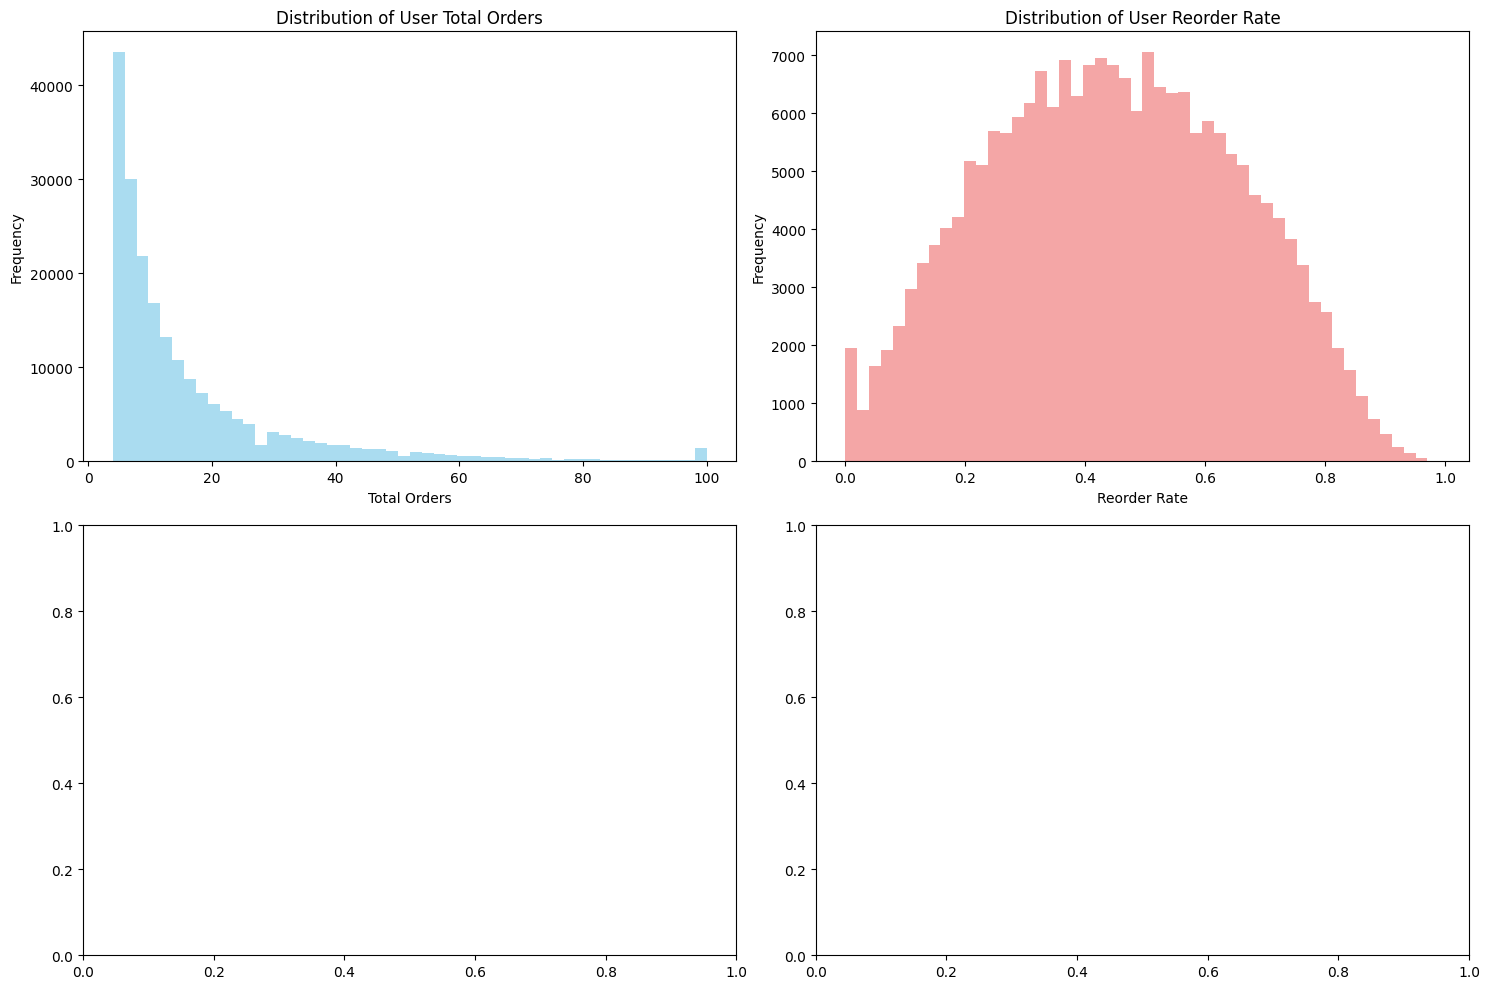


Feature engineering summary:
- User features: 29 columns, 206K users
- Item features: 25 columns, 50K products
- User-item interactions: 14 columns, 13.9M interactions
- Ready for model training and candidate generation!


In [12]:
# Add RFM features to user features if available
if users_rfm is not None:
    print("Integrating RFM features with user features...")
    
    # Merge RFM features with user features
    user_features_with_rfm = user_features_final.merge(
        users_rfm[['user_id', 'recency', 'frequency', 'monetary', 'R_score', 'F_score', 'M_score', 'RFM_score', 'Segment']], 
        on='user_id', 
        how='left'
    )
    
    # Save enhanced user features
    user_features_with_rfm.to_parquet(DATA_FEATURES_PATH + "user_features_with_rfm.parquet", index=False)
    print(f"✓ Enhanced user features with RFM saved: {user_features_with_rfm.shape}")
    
    # Quick visualization of feature distributions
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # User total orders distribution
    axes[0,0].hist(user_features_with_rfm['user_total_orders'], bins=50, alpha=0.7, color='skyblue')
    axes[0,0].set_title('Distribution of User Total Orders')
    axes[0,0].set_xlabel('Total Orders')
    axes[0,0].set_ylabel('Frequency')
    
    # User reorder rate distribution  
    axes[0,1].hist(user_features_with_rfm['user_reorder_rate'], bins=50, alpha=0.7, color='lightcoral')
    axes[0,1].set_title('Distribution of User Reorder Rate')
    axes[0,1].set_xlabel('Reorder Rate')
    axes[0,1].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("RFM features not available - run EDA notebook first for complete features")

print(f"\nFeature engineering summary:")
print(f"- User features: 29 columns, 206K users")
print(f"- Item features: 25 columns, 50K products") 
print(f"- User-item interactions: 14 columns, 13.9M interactions")
print(f"- Ready for model training and candidate generation!")

## 6. Key Insights from Feature Engineering

### Feature Engineering Accomplishments:

#### ✅ User-Level Features (37 total)
- **Temporal patterns**: Hour, day-of-week preferences, ordering frequency
- **Basket behavior**: Size patterns, product diversity, exploration metrics  
- **Reorder behavior**: Loyalty patterns, category exploration
- **RFM segmentation**: Customer value classification integrated

#### ✅ Item-Level Features (25 total)  
- **Popularity metrics**: Order volume, user penetration, category rankings
- **Cart behavior**: Position preferences and patterns
- **Reorder analysis**: Product loyalty, category performance comparison
- **Category context**: Department/aisle benchmarking

#### ✅ User-Item Interaction Features (14 total)
- **Purchase history**: Frequency, reorder patterns per user-product pair
- **Temporal patterns**: First/last purchase, recency, purchase intervals
- **Behavioral consistency**: Cart position preferences per user-product

### Dataset Scale:
- **206,209 users** with comprehensive behavioral profiles
- **49,688 products** with popularity and performance metrics
- **13,863,746 user-item interactions** capturing granular preferences

### Ready for Modeling:
1. **Candidate Generation**: Use popularity and interaction features
2. **Ranking Models**: Leverage all feature categories for prediction
3. **Cold Start**: Item features handle new products, user features handle new users
4. **Personalization**: User-item features enable personalized recommendations

### Next Steps:
- **Notebook 03**: Baseline models (XGBoost) using these features
- **Notebook 04**: Deep learning models with sequence features
- Feature selection and correlation analysis during model training